# **PROJET QUARTO PRATIQUE**



Les examens radiographiques pulmonaires sont l'un des examens d'imagerie médicale les plus fréquents et les plus rentables disponibles. Cependant, le diagnostic clinique d'une radiographie thoracique peut être difficile et parfois plus difficile que le diagnostic par imagerie CT thoracique. Le manque de grands ensembles de données accessibles au public avec des annotations signifie qu'il est encore très difficile, voire impossible, d'obtenir une détection et un diagnostic assistés par ordinateur (CAD) cliniquement pertinents dans des sites médicaux du monde réel avec des radiographies pulmonaires.

Cet ensemble de données comprend 5216 images de train, 624 images de test et 16 images de validation.

## **MODÈLE DE CLASSIFICATION : NORMAL ET PNEUMONIE**

### **Compréhension de la tache**

Avec cet ensemble de données, nous devons classer les images en deux classes (que la radiographie provienne d'un poumon normal ou d'un poumon atteint de pneumonie). Et ensuite, classez les poumons touchés en affection virale ou en affection bactérienne.

#### Importation des packages nécessaires pour le code

In [ ]:
from google.colab import drive
import os
import numpy as np
import pandas as pd
import random
import math
import cv2
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import (Conv2D, Conv2DTranspose, MaxPool2D, Dense, InputLayer, Flatten, Layer,
                                     BatchNormalization, Dropout, RandomRotation, RandomFlip)
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.callbacks import Callback, CSVLogger, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#### Mounting Google Drive

Cette partie est nécessaire pour obtenir le résultat du modèle pré-entraîné que nous avons créé.

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### **Data Importation**

Dans cette partie, nous obtiendrons notre base de données directement de Kaggle sans télécharger directement l'ensemble de données.

En effet, pour cette partie, vous devez importer le Kaggle Token qui vous sera fourni sous forme de *fichier json*. Vous devez importer ce fichier dans Colab, puis exécuter les codes ci-dessous.
D'abord vous devez avoir un compte Kaggle. Ensuite télécharger votre Token Kaggle. En effet, en cliquant sur l'icone de votre profil Kaggle en haut à droite dans Kaggle (il s'agit généralement d'une tête de canard), vous clique sur l'icone paramètres et en bas vous devriez voir un bouton 'Create Token' ou 'Créer un jeton'. Vous cliquez dessus et vous télécharger le token Kaggle. Ensuite, vous l'importer sur Colab à partir de l'onglet fichier dans le menu vertical à gauche de l'écran.

In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

Downloading with the Chest-Xray-Pneumonia API in Kaggle

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [01:17<00:00, 31.0MB/s]
100% 2.29G/2.29G [01:17<00:00, 31.8MB/s]


Unzipping the downloaded file

In [ ]:
!unzip \*.zip && rm *.zip

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-04

### **Data Visualization**

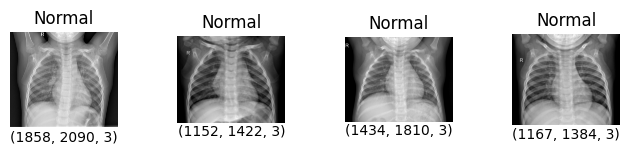

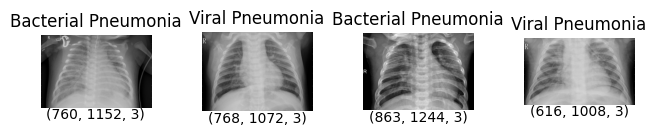

In [ ]:
paths = {'NORMAL':['/content/chest_xray/train/NORMAL/IM-0115-0001.jpeg', '/content/chest_xray/train/NORMAL/IM-0117-0001.jpeg', '/content/chest_xray/train/NORMAL/IM-0119-0001.jpeg', '/content/chest_xray/train/NORMAL/IM-0129-0001.jpeg'], 'PNEUMONIA': ['/content/chest_xray/train/PNEUMONIA/person1000_bacteria_2931.jpeg', '/content/chest_xray/train/PNEUMONIA/person1000_virus_1681.jpeg', '/content/chest_xray/train/PNEUMONIA/person1001_bacteria_2932.jpeg', '/content/chest_xray/train/PNEUMONIA/person1003_virus_1685.jpeg']}
for path in paths['NORMAL']:
    image = cv2.imread(path)
    image_arr = np.array(image)
    plt.Figure(figsize = (16,8))
    plt.subplot(1,len(paths['NORMAL']),paths['NORMAL'].index(path)+1)
    plt.imshow(image, cmap = 'Greys')
    plt.title('Normal')
    plt.text(0.5, -0.1, str(image_arr.shape), horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
    plt.tight_layout()
    plt.axis('off')
plt.show()
for path in paths['PNEUMONIA']:
    image = cv2.imread(path)
    image_arr = np.array(image)
    plt.Figure(figsize = (16,8))
    plt.subplot(1,len(paths['PNEUMONIA']),paths['PNEUMONIA'].index(path)+1)
    plt.imshow(image, cmap = 'Greys')
    if 'virus' in path:
      plt.title('Viral Pneumonia')
    else:
      plt.title('Bacterial Pneumonia')
    plt.text(0.5, -0.1, str(image_arr.shape), horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
    plt.tight_layout()
    plt.axis('off')
plt.show()

### **Data Preprocessing**

Dans cette partie, nous allons écrire un code pour extraire les images du répertoire du jeu de données Kaggle.

Ici, nous allons redimensionner les images, les remodeler et les normaliser. Nous utilisons la méthode de normalisation standard pour les ensembles de données d'image qui divise chaque pixel par 255

In [ ]:
#Function to load the training dataset
def load_train_data(path): #The path should the path to the train file in our chest_xray file
    train_data = []
    X_train = []
    y_train = []
    categories = os.listdir(path) #Extracting the name of the different files which are in the path we've specified
    # Here, the names are 'NORMAL' and 'PNEUMONIA'
    img_size = 150 #Defining the size the images we will be treating should have
    for category in categories:
      if category == 'NORMAL':
        full_path = os.path.join(path, category) #Creating the path which will lead to the content of the file
        # For instance, if category is 'NORMAL' then we will get the path to the content of the NORMAL file in train
        cat_index = categories.index(category) # Taking the index of each category in categories
        files = os.listdir(full_path) #Accessing the content of the NORMAL file
        # Here we are getting the names of the images in the NORMAL file for instance with the full_path
        for image in tqdm(files):
            image_arr = cv2.imread(os.path.join(full_path, image), cv2.IMREAD_GRAYSCALE) #Reading the image and setting the channel to 1 (GRAYSCALE)
            resized_image_arr = cv2.resize(image_arr, (img_size, img_size)) # Resizing the image to the shape (150,150)
            img_array = np.array(resized_image_arr)
            img_array_reshape = img_array.reshape(img_size, img_size, 1)
            img_tensor = tf.convert_to_tensor(img_array_reshape)
            img_flip_left_right = tf.image.flip_left_right(img_tensor)
            img_flip_left_right = img_flip_left_right.numpy()
            img_flip_up_down = tf.image.flip_up_down(img_tensor)
            img_flip_up_down = img_flip_up_down.numpy()
            train_data.append([img_array_reshape, cat_index])
            train_data.append([img_flip_left_right, cat_index])
            train_data.append([img_flip_up_down, cat_index])#Taking the images and the labels in a single dataset
      else:
        full_path = os.path.join(path, category) #Creating the path which will lead to the content of the file
        # For instance, if category is 'NORMAL' then we will get the path to the content of the NORMAL file in train
        cat_index = categories.index(category) # Taking the index of each category in categories
        files = os.listdir(full_path) #Accessing the content of the NORMAL file
        # Here we are getting the names of the images in the NORMAL file for instance with the full_path
        for image in tqdm(files):
            image_arr = cv2.imread(os.path.join(full_path, image), cv2.IMREAD_GRAYSCALE) #Reading the image and setting the channel to 1 (GRAYSCALE)
            resized_image_arr = cv2.resize(image_arr, (img_size, img_size)) # Resizing the image to the shape (150,150)
            img_array = np.array(resized_image_arr)
            img_array_reshape = img_array.reshape(img_size, img_size, 1)
            train_data.append([img_array_reshape, cat_index])
    random.shuffle(train_data) #Shuffling the dataset
    #Extracting the images and the labels from the dataset
    for x, y in train_data:
        X_train.append(x)
        y_train.append(y)
    train_mapping = {category:categories.index(category) for category in categories} #Clear vision of the different categories
    X_train = np.array(X_train).reshape(-1, img_size, img_size, 1) #Reshaping our X_train to permit it to enter in the model
    X_train = np.array(X_train)/255.0 # Normalization
    return X_train, y_train, train_mapping

Le même processus précédent s'applique ici aussi et aussi pour l'ensemble de données de validation

In [ ]:
def load_test_data(path):
    test_data = []
    X_test = []
    y_test = []
    categories = os.listdir(path)
    img_size = 150
    for category in categories:
        full_path = os.path.join(path,category)
        cat_index = categories.index(category)
        files = os.listdir(full_path)
        for image in tqdm(files):
            image_arr = cv2.imread(os.path.join(full_path,image),cv2.IMREAD_GRAYSCALE)
            resized_image_arr = cv2.resize(image_arr,(img_size,img_size))
            test_data.append([resized_image_arr,cat_index])
    random.shuffle(test_data)
    for x,y in test_data:
        X_test.append(x)
        y_test.append(y)
    test_mapping = {category:categories.index(category) for category in categories}
    X_test = np.array(X_test).reshape(-1,img_size,img_size,1)
    X_test = np.array(X_test)/255.0
    return X_test, y_test, test_mapping

Extracting our files

In [ ]:
X_train, y_train, train_mapping = load_train_data('/content/chest_xray/train')
X_test, y_test, test_mapping = load_test_data('/content/chest_xray/test')

100%|██████████| 390/390 [00:01<00:00, 212.42it/s]


Conversion des étiquettes dans un format plus compréhensible pour le modèle

In [ ]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
y_train = y_train.astype('float64')
y_test = y_test.astype('float64')

{'NORMAL': 0, 'PNEUMONIA': 1}
{'NORMAL': 0, 'PNEUMONIA': 1}


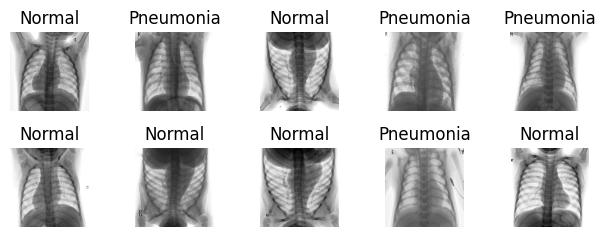

In [ ]:
plt.Figure(figsize = (16,8))
print(train_mapping)
print(test_mapping)
for i in range(10):
  plt.subplot(4,5,i+1)
  plt.imshow(X_train[i], cmap = 'Greys')
  if y_train[i] == 0:
    plt.title('Normal')
  else:
    plt.title('Pneumonia')
  plt.axis('off')
  plt.tight_layout()
plt.show()

### **Model Creation**

**CONVOLUTIONAL NEURAL NETWORK**



Ici, nous allons définir la structure de notre modèle et définir son architecture spécifique. Nous suivons l'architecture du modèle CNN de Yann Lecun pour la classification des images afin de déterminer le nombre de couches convolutives (et aussi les différents hyperparamètres de chaque couche convolutive), le nombre de couche Dense (pour la spécification du réseau de neurones entièrement connecté dans lequel les principales caractéristiques de chaque image seront traitées et extraites pour produire le résultat).

Nous modifions également l'architecture afin d'adapter nos données puisque cette base de données n'est pas si grande et n'a pas besoin d'un modèle complexe pour la traiter au risque de commettre un surajustement. Puis finalement, nous en sommes arrivés à ce modèle qui s'adapte bien à nos données et propose une descente des prédictions pour les images. Nous avons essayé plusieurs architectures et celle-ci semble être la meilleure

In [ ]:
img_size = 150
model = tf.keras.Sequential([InputLayer(input_shape = (img_size,img_size,1)),
      tf.keras.layers.Conv2D(filters=4, kernel_size=3, strides=1, padding = 'valid', activation='relu'),
      BatchNormalization(),
      tf.keras.layers.MaxPool2D(pool_size=2, strides=2),

      tf.keras.layers.Conv2D(filters=8, kernel_size=3, strides=1, activation='relu', padding="valid"),
      BatchNormalization(),
      tf.keras.layers.MaxPool2D(pool_size=2, strides = 2),

      tf.keras.layers.Flatten(),

      tf.keras.layers.Dense(10,activation='relu'),
      BatchNormalization(),
      Dropout(0.5),
      tf.keras.layers.Dense(5,activation='relu'),
      BatchNormalization(),
      Dropout(0.5),
      tf.keras.layers.Dense(1,activation='sigmoid')
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 4)       40        
                                                                 
 batch_normalization_8 (Batc  (None, 148, 148, 4)      16        
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 74, 74, 4)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 8)         296       
                                                                 
 batch_normalization_9 (Batc  (None, 72, 72, 8)        32        
 hNormalization)                                                 
                                                      

Nous avons un total de 104141 paramètres entraînables

Compilation du modèle pour le montage. Ici, nous utilisons l'optimiseur Adam. C'est un excellent algorithme pour minimiser la perte et améliorer la précision du train comme l'algorithme de descente de gradient (SGD dans tensorflow). Les deux sont les optimiseurs standard utilisés dans les problèmes de classification d'images. Nous avons choisi l'optimiseur Adam (Adaptive Moment Estimation) en raison de sa convergence la plus rapide et du fait que l'algorithme adapte automatiquement le taux d'apprentissage qui l'amène plus rapidement au point de convergence. Et enfin, la gestion de la mémoire. De telles tâches peuvent être coûteuses en termes de consommation de mémoire. L'algorithme Adam simplifie le processus en utilisant
moyennes mobiles des gradients précédents pour mettre à jour les paramètres, ce qui lui permet de prendre en compte l'historique des gradients et de gérer plus efficacement les problèmes liés à la mémoire dans les réseaux de neurones profonds.

Nous avons également utilisé le "binary_crossentropy loss function"  car nous sommes dans le cas d'une classification binaire.
La métrique est la précision qui indique le pourcentage de prédictions vraies sur l'ensemble de données.

In [ ]:
model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

#### Improving Model performance

Après avoir compilé et ajusté le modèle, nous pouvons voir que notre modèle apprend bien jusqu'à certains points où il va et vient et oscille. Ensuite, nous implémentons la méthode de rappel fournie par tensorflow qui est earlyStoppingCallback et nous spécifions le mode pour maximiser la précision de validation et et si cela va et vient pour prendre la meilleure précision de validation que le modèle a obtenue et prendre ces poids ou paramètres.

In [ ]:
early_stopping_callbacks = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta = 0,
    patience = 100,
    mode = 'max',
    baseline = 0.95,
    restore_best_weights= True
)

In [ ]:
history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 20, callbacks = [early_stopping_callbacks],shuffle = True, verbose = 1)

Epoch 1/20
247/247 [==============================] - 7s 15ms/step - loss: 0.4131 - accuracy: 0.8197 - val_loss: 0.7334 - val_accuracy: 0.6234
Epoch 2/20
247/247 [==============================] - 2s 9ms/step - loss: 0.2665 - accuracy: 0.8969 - val_loss: 0.7426 - val_accuracy: 0.6763
Epoch 3/20
247/247 [==============================] - 2s 9ms/step - loss: 0.2087 - accuracy: 0.9209 - val_loss: 1.0225 - val_accuracy: 0.6474
Epoch 4/20
247/247 [==============================] - 2s 9ms/step - loss: 0.1789 - accuracy: 0.9353 - val_loss: 1.2388 - val_accuracy: 0.6394
Epoch 5/20
247/247 [==============================] - 2s 10ms/step - loss: 0.1349 - accuracy: 0.9520 - val_loss: 1.0534 - val_accuracy: 0.7115
Epoch 6/20
247/247 [==============================] - 3s 13ms/step - loss: 0.1301 - accuracy: 0.9497 - val_loss: 0.7553 - val_accuracy: 0.7692
Epoch 7/20
247/247 [==============================] - 3s 12ms/step - loss: 0.1116 - accuracy: 0.9595 - val_loss: 0.5479 - val_accuracy: 0.8301
Ep

**Saving Model**

In [ ]:
#model.save('/content/gdrive/MyDrive/Saved Models/Model.h5')

To reload this model, you should first run the code 'drive.mount('/content/gdrive')'. Then you import the files in your drive especially in the file named MyDrive. And then you run the code 'model = tf.keras.models.load_model('/content/gdrive/MyDrive/Model.h5')'

In [ ]:
model = tf.keras.models.load_model('/content/gdrive/MyDrive/Machine Learning Project/Saved Models/Model.h5')

### **Model Evaluation and Testing**

We can see that our model overfits a little bit and that can be either be caused by the model complexity (the model is too complex and fits really quick to the train set and forgetting the test set) or the images' quality (the images are too blurry).

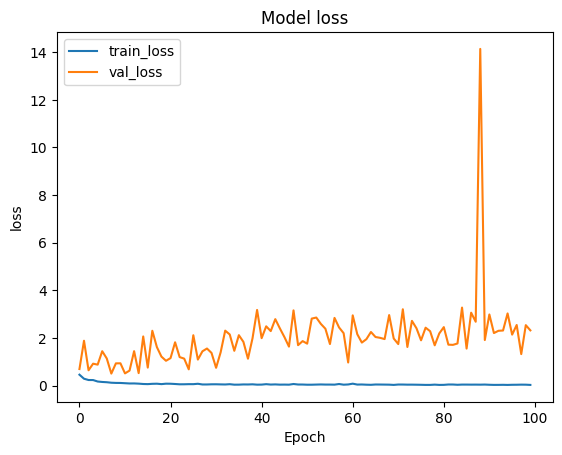

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(['train_loss','val_loss'])
plt.show()

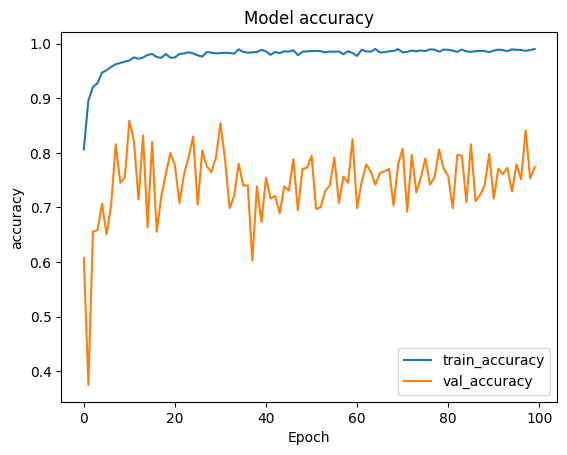

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend(['train_accuracy','val_accuracy'])
plt.show()

Nonetheless, we've got a train accuracy of 97,91% and 85,9 % for the test accuracy. Which means a total of 15% error in the test set. That is a descent result. An approach to solve the problem is Data augmentation which consists of increasing the train dataset and test dataset size.

This can either be done with *tf.image* or *tensorflow layers*. Therefore it's important not to increase the sizes too much because that could lead to underfitting. For memory purposes, this is not implemented

In [ ]:
model.evaluate(X_train, y_train)
model.evaluate(X_test, y_test)

20/20 [==============================] - 0s 6ms/step - loss: 0.7335 - accuracy: 0.8429


[0.7334960699081421, 0.8429487347602844]

Prediction for a single image in the train set

In [ ]:
print(X_train.shape)
print(X_train[0].shape)
image = X_train[0].reshape(1,150,150,1)

(5216, 150, 150, 1)
(150, 150, 1)


In [ ]:
prediction_of_image = model.predict(image)
prediction_of_image

1/1 [==============================] - 0s 168ms/step


array([[0.98464817]], dtype=float32)

In [ ]:
prediction_of_image_probability = prediction_of_image.item()
prediction_of_image_probability

0.9846481680870056

## **CLASSIFYING VIRAL AND BACTERIAL PNEUMONIA**

Dans cet ensemble de données, nous avons également différents types de pneumonie (pneumonie virale et bactérienne). Cette partie est dédiée à la classification des images précédemment classées pneumonie en deux classes (Viral ou bactérien)

### **Data Preparation**

On commence avec la préparation de la base de données

### **Data Preprocessing**

Le processus de ce code est en fait le même que les fonctions d'importation précédentes que nous avons définies précédemment.

In [ ]:
def load_train_pneumonia_data(path):
  train_data = []
  X_pneumonia_train = []
  y_pneumonia_train = []
  images_name = os.listdir(path)
  img_size = 150
  pathology = {'bacterial':0, 'viral':1}
  for image_name in tqdm(images_name):
    if 'bacteria' in image_name:
      cat_index = pathology['bacterial']
    else:
      cat_index = pathology['viral']
    image_arr = cv2.imread(os.path.join(path, image_name), cv2.IMREAD_GRAYSCALE)
    resized_image_arr = cv2.resize(image_arr, (img_size, img_size))
    train_data.append([resized_image_arr, cat_index])
  random.shuffle(train_data)
  for x, y in train_data:
    X_pneumonia_train.append(x)
    y_pneumonia_train.append(y)
  X_pneumonia_train = np.array(X_pneumonia_train).reshape(-1, img_size, img_size, 1)
  X_pneumonia_train = np.array(X_pneumonia_train)/255.0
  return X_pneumonia_train, y_pneumonia_train, pathology

In [ ]:
def load_test_pneumonia_data(path):
  test_data = []
  X_pneumonia_test = []
  y_pneumonia_test = []
  images_name = os.listdir(path)
  img_size = 150
  pathology = {'bacterial':0, 'viral':1}
  for image_name in tqdm(images_name):
    if 'bacteria' in image_name:
      cat_index = pathology['bacterial']
    else:
      cat_index = pathology['viral']
    image_arr = cv2.imread(os.path.join(path, image_name), cv2.IMREAD_GRAYSCALE)
    resized_image_arr = cv2.resize(image_arr, (img_size, img_size))
    test_data.append([resized_image_arr, cat_index])
  random.shuffle(test_data)
  for x, y in test_data:
    X_pneumonia_test.append(x)
    y_pneumonia_test.append(y)
  X_pneumonia_test = np.array(X_pneumonia_test).reshape(-1, img_size, img_size, 1)
  X_pneumonia_test = np.array(X_pneumonia_test)/255.0
  return X_pneumonia_test, y_pneumonia_test, pathology

In [ ]:
def load_val_pneumonia_data(path):
  val_data = []
  X_pneumonia_val = []
  y_pneumonia_val = []
  images_name = os.listdir(path)
  img_size = 150
  pathology = {'bacterial':0, 'viral':1}
  for image_name in tqdm(images_name):
    if 'bacteria' in image_name:
      cat_index = pathology['bacterial']
    else:
      cat_index = pathology['viral']
    image_arr = cv2.imread(os.path.join(path, image_name), cv2.IMREAD_GRAYSCALE)
    resized_image_arr = cv2.resize(image_arr, (img_size, img_size))
    val_data.append([resized_image_arr, cat_index])
  random.shuffle(val_data)
  for x, y in val_data:
    X_pneumonia_val.append(x)
    y_pneumonia_val.append(y)
  X_pneumonia_val = np.array(X_pneumonia_val).reshape(-1, img_size, img_size, 1)
  X_pneumonia_val = np.array(X_pneumonia_val)/255.0
  return X_pneumonia_val, y_pneumonia_val, pathology

In [ ]:
X_pneumonia_train, y_pneumonia_train, pathology = load_train_pneumonia_data('/content/chest_xray/train/PNEUMONIA')
X_pneumonia_test, y_pneumonia_test, pathology = load_test_pneumonia_data('/content/chest_xray/test/PNEUMONIA')
X_pneumonia_val, y_pneumonia_val, pathology = load_val_pneumonia_data('/content/chest_xray/val/PNEUMONIA')

100%|██████████| 8/8 [00:00<00:00, 166.30it/s]


In [ ]:
y_pneumonia_train = np.array(y_pneumonia_train)
y_pneumonia_test = np.array(y_pneumonia_test)
y_pneumonia_val = np.array(y_pneumonia_val)

In [ ]:
y_pneumonia_train = y_pneumonia_train.astype('float64')
y_pneumonia_test = y_pneumonia_test.astype('float64')
y_pneumonia_val = y_pneumonia_val.astype('float64')

### **Data Visualization**

{'bacterial': 0, 'viral': 1}


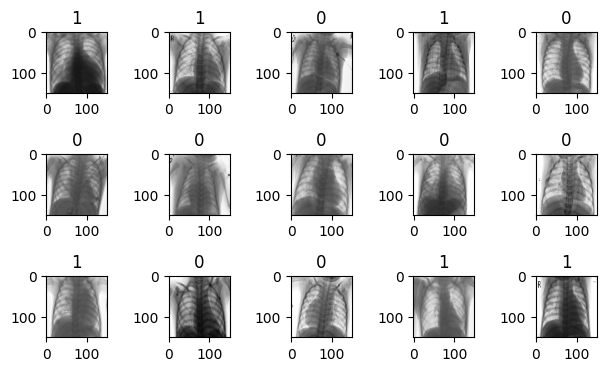

In [ ]:
plt.Figure(figsize = (16, 8))
print(pathology)
for i in range(15):
  plt.subplot(4,5,i+1)
  plt.imshow(X_pneumonia_train[i], cmap = 'Greys')
  plt.title(y_pneumonia_train[i])
  plt.tight_layout()
plt.show()

### **Model Creation**

**CONVOLUTIONAL NEURAL NETWORK**

Importation de mesures supplémentaires et de packages de tracés

In [ ]:
from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC
import sklearn
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns

Model architecture

In [ ]:
img_size = 150
pathology_model = tf.keras.Sequential([InputLayer(input_shape = (img_size,img_size,1)),
      tf.keras.layers.Conv2D(filters=4, kernel_size=3, strides=1, padding = 'valid', activation='relu'),
      BatchNormalization(),
      tf.keras.layers.MaxPool2D(pool_size=2, strides=2),

      tf.keras.layers.Conv2D(filters=8, kernel_size=3, strides=1, activation='relu', padding="valid"),
      BatchNormalization(),
      tf.keras.layers.MaxPool2D(pool_size=2, strides = 2),

      tf.keras.layers.Flatten(),

      tf.keras.layers.Dense(14,activation='relu'),
      Dropout(0.5),
      tf.keras.layers.Dense(6,activation='relu'),
      Dropout(0.2),
      tf.keras.layers.Dense(1,activation='sigmoid')
])
pathology_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 4)       40        
                                                                 
 batch_normalization (BatchN  (None, 148, 148, 4)      16        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 4)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 8)         296       
                                                                 
 batch_normalization_1 (Batc  (None, 72, 72, 8)        32        
 hNormalization)                                                 
                                                        

Some callbacks to ensure that the training is going well overall

CSVLogger

We use the CSVLogger callback to get the loss and the metrics after the training. It is a CSV file.

In [ ]:
csv_callback = CSVLogger('logs.csv', separator = ",", append = False)

EarlyStopping

In [ ]:
nb_epoch = 100

In [ ]:
pathology_early_stopping_callbacks = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta = 0,
    patience = nb_epoch,
    mode = 'max',
    baseline = 0.95,
    restore_best_weights= True
)

In [ ]:
pathology_early_stopping_callbacks_2 = tf.keras.callbacks.EarlyStopping(
    monitor='accuracy',
    min_delta = 0,
    patience = nb_epoch,
    mode = 'max',
    baseline = 0.95,
    restore_best_weights= True
)

LearningRateScheduler

Model Training

We add some metrics to the compilation.

In [ ]:
metrics = [
    TruePositives(name = 'tp'), TrueNegatives(name = 'tn'), FalsePositives(name = 'fp'),
    FalseNegatives(name = 'fn'), BinaryAccuracy(name = 'accuracy'), Recall(name = 'recall'),
    Precision(name = 'precision'), AUC(name = 'auc')
    ]

In [ ]:
pathology_model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = metrics)

In [ ]:
pathology_history = pathology_model.fit(X_pneumonia_train, y_pneumonia_train, validation_data = (X_pneumonia_test, y_pneumonia_test), epochs = 100, callbacks = [pathology_early_stopping_callbacks, pathology_early_stopping_callbacks_2, csv_callback],shuffle = True, verbose = 1)

Epoch 1/100
122/122 [==============================] - 2s 14ms/step - loss: 0.4159 - tp: 1319.0000 - tn: 1597.0000 - fp: 933.0000 - fn: 26.0000 - accuracy: 0.7525 - recall: 0.9807 - precision: 0.5857 - auc: 0.8255 - val_loss: 0.6804 - val_tp: 119.0000 - val_tn: 227.0000 - val_fp: 15.0000 - val_fn: 29.0000 - val_accuracy: 0.8872 - val_recall: 0.8041 - val_precision: 0.8881 - val_auc: 0.9101
Epoch 2/100
122/122 [==============================] - 1s 9ms/step - loss: 0.4077 - tp: 1306.0000 - tn: 1631.0000 - fp: 899.0000 - fn: 39.0000 - accuracy: 0.7579 - recall: 0.9710 - precision: 0.5923 - auc: 0.8264 - val_loss: 0.6886 - val_tp: 125.0000 - val_tn: 222.0000 - val_fp: 20.0000 - val_fn: 23.0000 - val_accuracy: 0.8897 - val_recall: 0.8446 - val_precision: 0.8621 - val_auc: 0.9088
Epoch 3/100
122/122 [==============================] - 1s 9ms/step - loss: 0.4013 - tp: 1307.0000 - tn: 1683.0000 - fp: 847.0000 - fn: 38.0000 - accuracy: 0.7716 - recall: 0.9717 - precision: 0.6068 - auc: 0.8387 - 

**Saving model**

In [ ]:
#pathology_model.save('/content/gdrive/MyDrive/Models Hamid/Pathology_Model.h5')

To reload this model, you should first run the code 'drive.mount('/content/gdrive')'. Then you import the Saved Models file in your drive especially in the file named MyDrive. And then you run the code 'pathology_model = tf.keras.models.load_model('/content/gdrive/MyDrive/Saved Models/Pathology_Model.h5')'

In [ ]:
pathology_model = tf.keras.models.load_model('/content/gdrive/MyDrive/Machine Learning Project/Saved Models/Pathology_Model.h5')

### **Model Evaluation and Testing**

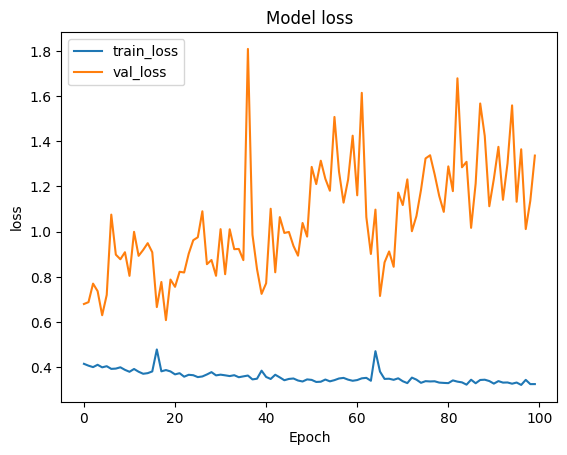

In [ ]:
plt.plot(pathology_history.history['loss'])
plt.plot(pathology_history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(['train_loss','val_loss'])
plt.show()

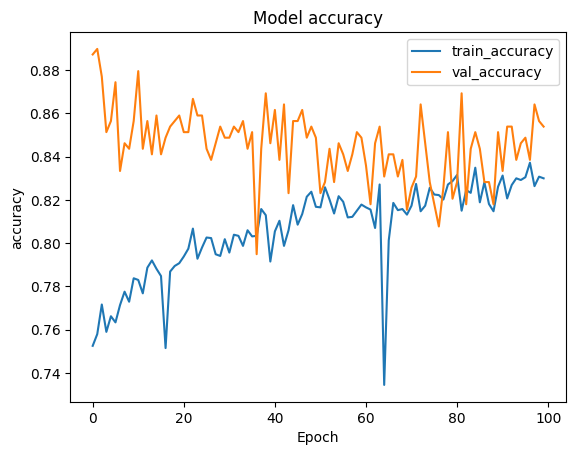

In [ ]:
plt.plot(pathology_history.history['accuracy'])
plt.plot(pathology_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend(['train_accuracy','val_accuracy'])
plt.show()

Here, we have a train score of 95,38 % and a test score of 83.85 %. That mean we have a total of 17 % error on the test set.

In [ ]:
pathology_model.evaluate(X_pneumonia_train, y_pneumonia_train)
pathology_model.evaluate(X_pneumonia_test, y_pneumonia_test)

13/13 [==============================] - 2s 141ms/step - loss: 1.3645 - tp: 105.0000 - tn: 222.0000 - fp: 20.0000 - fn: 43.0000 - accuracy: 0.8385 - recall: 0.7095 - precision: 0.8400 - auc: 0.8822


[1.3645029067993164,
 105.0,
 222.0,
 20.0,
 43.0,
 0.8384615182876587,
 0.7094594836235046,
 0.8399999737739563,
 0.8821895122528076]

Prediction for a single image

In [ ]:
print(X_pneumonia_test.shape)
pathology_image = X_pneumonia_test[0].reshape(1,150,150,1)
print(X_pneumonia_test[1].shape)

(390, 150, 150, 1)
(150, 150, 1)


In [ ]:
pathology_prediction_of_image = pathology_model.predict(pathology_image)
pathology_prediction_of_image

1/1 [==============================] - 0s 170ms/step


array([[1.4614578e-19]], dtype=float32)

In [ ]:
pathology_prediction_of_image_probability = pathology_prediction_of_image.item()
pathology_prediction_of_image_probability

1.4614577948738023e-19

**VISUALIZING CONFUSION MATRIX**

Here, we are going to look at the confusion matrix of the first classifier (Model).

In [ ]:
predicted = model.predict(X_test)
print(predicted.shape)
predicted = predicted.reshape(predicted.shape[0],)
labels = y_test.reshape(predicted.shape[0],)

20/20 [==============================] - 2s 119ms/step
(624, 1)


In [ ]:
print(train_mapping)

{'NORMAL': 0, 'PNEUMONIA': 1}


Nous définissons le seuil à 0,5 pour voir à quoi ressemble la matrice de confusion. Le but de cette manœuvre est de réduire les erreurs de prédiction graves du modèle. Par exemple, si certains enfants ont une pneumonie et que le modèle prédit une situation normale. Cela peut être grave et avoir de lourdes conséquences. Nous essayons donc de réduire le nombre de ces erreurs de classification sans trop diminuer le nombre d'erreurs de classification des radiographies pulmonaires normales (images normales mais prédisant une pneumonie)

[[157  77]
 [ 11 379]]


Text(0.5, 23.52222222222222, 'Predicted')

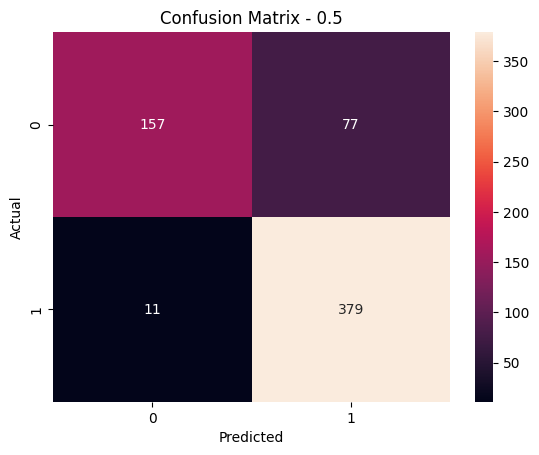

In [ ]:
threshold = 0.5
cm = confusion_matrix(labels, predicted > threshold)
print(cm)
plt.Figure(figsize = (16,8))
sns.heatmap(cm, annot = True, fmt='d')
plt.title('Confusion Matrix - {}'.format(threshold))
plt.ylabel('Actual')
plt.xlabel('Predicted')

**ROC Plots (Receiver Operating Characteristic)**

140 140 140


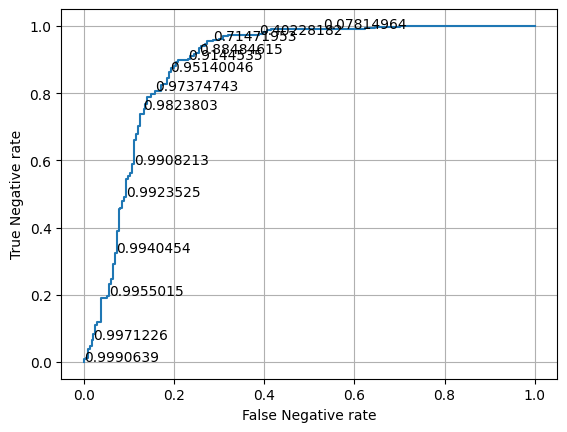

In [ ]:
fn, tn, threshold = roc_curve(labels, predicted)
print(len(fn), len(tn), len(threshold))
plt.Figure(figsize = (16, 16))
plt.plot(fn, tn)
plt.xlabel('False Negative rate')
plt.ylabel('True Negative rate')
plt.grid()
skip = 10

for i in range(1, len(threshold), skip):
  plt.text(fn[i], tn[i], threshold[i])
plt.show()

Sur la base de cette courbe ROC, puisque notre modèle est programmé de telle sorte que 1 signifie Pneumonie (Positif) et 0 signifie Normal (Négatif), nous essayons de réduire le nombre de faux négatifs. Cela signifie que nous essayons le nombre d'images de pneumonie qui sont prédites normales. Ensuite, pour réduire le taux de faux négatifs sans trop réduire le taux de vrais positifs, en se basant sur la courbe ROC, il faudrait prendre une valeur de seuil entre 0,5 et 0,4 pour réduire le taux de faux négatifs. Dans ce cas, il semble que prendre le seuil à 0,5 soit la meilleure chose possible. Nous prendrons donc le seuil à 0,5 dans le reste du travail pour "modèle"

Reducing the number of misclassification of bacterial pneumonia for the pathology model

In [ ]:
pathology_predicted = pathology_model.predict(X_pneumonia_test)
print(pathology_predicted.shape)
pathology_predicted = pathology_predicted.reshape(pathology_predicted.shape[0],)
pathology_labels = y_pneumonia_test.reshape(pathology_predicted.shape[0],)

13/13 [==============================] - 3s 210ms/step
(390, 1)


In [ ]:
print(pathology)

{'bacterial': 0, 'viral': 1}


[[222  20]
 [ 43 105]]


Text(0.5, 23.52222222222222, 'Predicted')

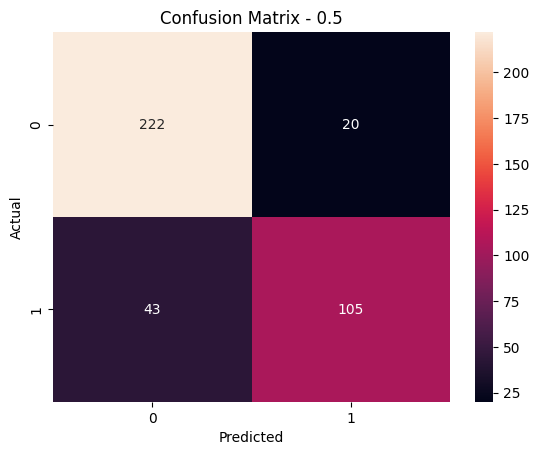

In [ ]:
threshold = 0.5
pathology_cm = confusion_matrix(pathology_labels, pathology_predicted > threshold)
print(pathology_cm)
plt.Figure(figsize = (16,8))
sns.heatmap(pathology_cm, annot = True, fmt='d')
plt.title('Confusion Matrix - {}'.format(threshold))
plt.ylabel('Actual')
plt.xlabel('Predicted')

67 67 67


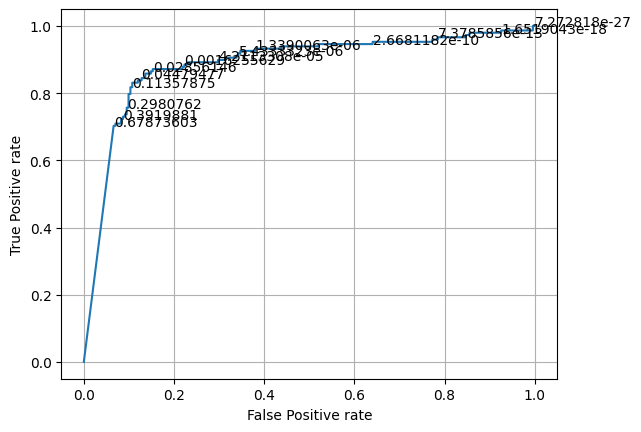

In [ ]:
fp, tp, threshold = roc_curve(pathology_labels, pathology_predicted)
print(len(fp), len(tp), len(threshold))
plt.Figure(figsize = (16, 16))
plt.plot(fp, tp)
plt.xlabel('False Positive rate')
plt.ylabel('True Positive rate')
plt.grid()
skip = 5

for i in range(1, len(threshold), skip):
  plt.text(fp[i], tp[i], threshold[i])
plt.show()

Étant donné que les pneumonies bactériennes sont plus dangereuses que les virales en général, nous allons essayer de réduire le nombre de virus prédits mais réellement bactériens. Sur la base de la courbe ROC ci-dessus, un seuil de 0,6 semble être un bon compromis.

[[226  16]
 [ 44 104]]


Text(0.5, 23.52222222222222, 'Predicted')

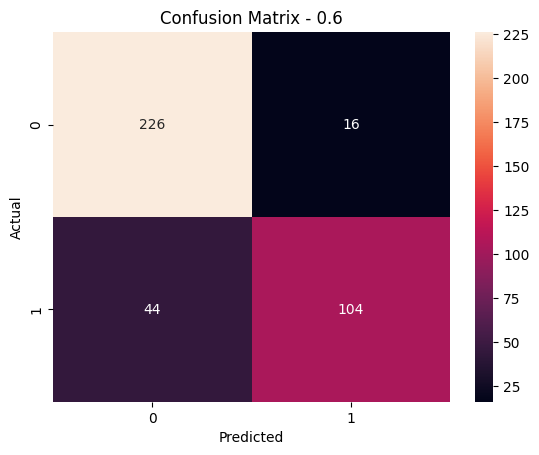

In [ ]:
threshold = 0.6
pathology_cm = confusion_matrix(pathology_labels, pathology_predicted > threshold)
print(pathology_cm)
plt.Figure(figsize = (16,8))
sns.heatmap(pathology_cm, annot = True, fmt='d')
plt.title('Confusion Matrix - {}'.format(threshold))
plt.ylabel('Actual')
plt.xlabel('Predicted')

**IMPLEMENTATING FUNCTION**

We define a final function which implements those models and return the result of all the previous classification.

Generating the image

In [ ]:
def image_generator(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    yield {'image': image}

Resizing, rescaling and normalizing

In [ ]:
def resize_rescale_normalize(path):
  img_size = 150
  image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
  image = cv2.resize(image, (img_size,img_size))
  image_arr = np.array(image).reshape(1,img_size,img_size,1)
  image_arr = np.array(image_arr)/255.0
  return image, image_arr

Prediction function

In [ ]:
def prediction_with_path(x_ray_path):
  image, image_arr = resize_rescale_normalize(x_ray_path)
  prediction = model.predict(image_arr)
  prediction_probability = prediction.item()
  print(prediction_probability)
  image_data = tf.data.Dataset.from_generator(
        lambda: image_generator(x_ray_path),
        output_signature={'image': tf.TensorSpec(shape=[None, None], dtype=tf.int64)})
  sample = next(iter(image_data.take(1)))
  image_print = sample['image']
  if prediction_probability < 0.5:
    label = 'Normal'
    plt.Figure(figsize = (16,8))
    plt.imshow(image_print)
    plt.title(label)
    plt.axis('off')
    plt.show()
  else:
    label = 'pneumonia'
    pathology_prediction = pathology_model.predict(image_arr)
    pathology_prediction_probability = pathology_prediction.item()
    print(pathology_prediction_probability)
    if pathology_prediction_probability > 0.6:
      pathology = 'Viral'
    else:
      pathology = 'Bacterial'
    plt.Figure(figsize = (16,8))
    plt.imshow(image_print)
    plt.title(pathology + " " + label)
    plt.axis('off')
    plt.show()

1/1 [==============================] - 0s 93ms/step
0.9438753724098206
1/1 [==============================] - 0s 95ms/step
0.0016247907187789679


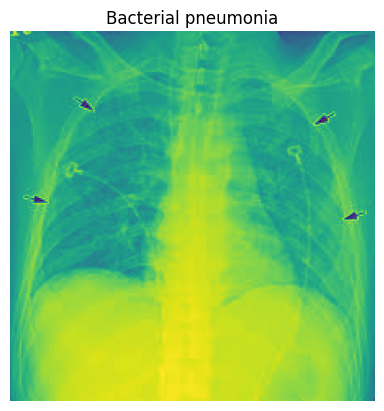

In [ ]:
prediction_with_path('/content/Viral4.jpg')

## ANOMALY DETECTION MODEL

Dans cette partie, nous allons classer les images en fonction du modèle de détection d'anomalies. Ce modèle utilise un encodeur qui prend les images de pneumonie en entrée et utilise des couches convolutives pour extraire les principales caractéristiques de l'image afin de faire la différence entre les images de pneumonie et les images de poumons normaux. Le décodeur prend les caractéristiques et génère une image qui ressemble à l'image d'entrée et apprend comment sont les images de pneumonie. Il apprend les différentes caractéristiques inhérentes aux images de pneumonie. Et puis face à des images radiographiques normales, la perte devrait être plus importante et cela signifie que la configuration des images normales est différente de la configuration des images radiographiques. C'est ainsi qu'il procède pour faire la classification

### Data preparation

Loading the data. The same process as the other codes for importation

In [ ]:
def load_train_pn_resized_data(path):
  kernel = np.array([[0, -1, 0],[-1, 5, -1],[0, -1, 0]])
  train_data = []
  X_pn_train = []
  y_pn_train = []
  images_name = os.listdir(path)
  img_size = 160
  pathology = {'bacterial':0, 'viral':1}
  for image_name in tqdm(images_name):
    if 'bacteria' in image_name:
      cat_index = pathology['bacterial']
    else:
      cat_index = pathology['viral']
    image_arr = cv2.imread(os.path.join(path, image_name), cv2.IMREAD_GRAYSCALE)
    image_arr = cv2.filter2D(image_arr, -1, kernel)
    resized_image_arr = cv2.resize(image_arr, (img_size, img_size))
    train_data.append([resized_image_arr, cat_index])
  random.shuffle(train_data)
  for x, y in train_data:
    X_pn_train.append(x)
    y_pn_train.append(y)
  X_pn_train = np.array(X_pn_train).reshape(-1, img_size, img_size, 1)
  X_pn_train = np.array(X_pn_train)/255.0
  return X_pn_train, y_pn_train

In [ ]:
def load_test_pn_resized_data(path):
  kernel = np.array([[0, -1, 0],[-1, 5, -1],[0, -1, 0]])
  test_data = []
  X_pn_test = []
  y_pn_test = []
  images_name = os.listdir(path)
  img_size = 160
  pathology = {'bacterial':0, 'viral':1}
  for image_name in tqdm(images_name):
    if 'bacteria' in image_name:
      cat_index = pathology['bacterial']
    else:
      cat_index = pathology['viral']
    image_arr = cv2.imread(os.path.join(path, image_name), cv2.IMREAD_GRAYSCALE)
    image_arr = cv2.filter2D(image_arr, -1, kernel)
    resized_image_arr = cv2.resize(image_arr, (img_size, img_size))
    test_data.append([resized_image_arr, cat_index])
  random.shuffle(test_data)
  for x, y in test_data:
    X_pn_test.append(x)
    y_pn_test.append(y)
  X_pn_test = np.array(X_pn_test).reshape(-1, img_size, img_size, 1)
  X_pn_test = np.array(X_pn_test)/255.0
  return X_pn_test, y_pn_test

In [ ]:
X_pn_train, y_pn_train = load_train_pn_resized_data('/content/chest_xray/train/PNEUMONIA')
X_pn_test, y_pn_test = load_test_pn_resized_data('/content/chest_xray/test/PNEUMONIA')

100%|██████████| 390/390 [00:02<00:00, 167.48it/s]


In [ ]:
X_nr_train, y_nr_train = load_train_pn_resized_data('/content/chest_xray/train/NORMAL')
X_nr_test, y_nr_test = load_test_pn_resized_data('/content/chest_xray/test/NORMAL')

100%|██████████| 234/234 [00:04<00:00, 50.53it/s]


### Model Creation

We create a class which inherits from the Model class in tensorflow.keras. That class contains the encoder, the decoder and returns the decoded image of the input.

In [ ]:
class AnomalyDetector(tf.keras.Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same', input_shape=(160, 160, 1)),
        tf.keras.layers.MaxPooling2D(2, padding='same'),
        tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2, padding='same'),
        tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2, padding='same'),
        tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2, padding='same')
    ])
    self.decoder = tf.keras.Sequential([
        tf.keras.layers.Conv2DTranspose(128, 3, strides=2, activation='relu', padding='same'),
        tf.keras.layers.Conv2DTranspose(64, 3, strides=2, activation='relu', padding='same'),
        tf.keras.layers.Conv2DTranspose(32, 3, strides=2, activation='relu', padding='same'),
        tf.keras.layers.Conv2DTranspose(1, 3, strides=2, activation='sigmoid', padding='same')
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()
autoencoder.build((None, 160, 160, 1))
autoencoder.summary()

Model: "anomaly_detector"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 10, 10, 256)       387840    
                                                                 
 sequential_1 (Sequential)   (None, 160, 160, 1)       387585    
                                                                 
Total params: 775,425
Trainable params: 775,425
Non-trainable params: 0
_________________________________________________________________


In [ ]:
loss_callback = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    patience = 10,
    mode = 'min',
    restore_best_weights=True
)

### Model training

The model will be trained only with the pneumonia images on the encoder in order to extract the maximum information from the

In [ ]:
autoencoder.compile(optimizer = 'adam', loss='mae')

In [ ]:
ad_history = autoencoder.fit(X_pn_train, X_pn_train, validation_data = (X_pn_test, X_pn_test), epochs = 20, callbacks=[loss_callback], shuffle = True, verbose = 1)

Epoch 1/20
122/122 [==============================] - 8s 41ms/step - loss: 0.1123 - val_loss: 0.0515
Epoch 2/20
122/122 [==============================] - 5s 38ms/step - loss: 0.0470 - val_loss: 0.0429
Epoch 3/20
122/122 [==============================] - 5s 37ms/step - loss: 0.0424 - val_loss: 0.0410
Epoch 4/20
122/122 [==============================] - 5s 37ms/step - loss: 0.0403 - val_loss: 0.0406
Epoch 5/20
122/122 [==============================] - 5s 38ms/step - loss: 0.0390 - val_loss: 0.0395
Epoch 6/20
122/122 [==============================] - 5s 38ms/step - loss: 0.0378 - val_loss: 0.0389
Epoch 7/20
122/122 [==============================] - 5s 38ms/step - loss: 0.0370 - val_loss: 0.0385
Epoch 8/20
122/122 [==============================] - 5s 39ms/step - loss: 0.0365 - val_loss: 0.0373
Epoch 9/20
122/122 [==============================] - 5s 38ms/step - loss: 0.0357 - val_loss: 0.0352
Epoch 10/20
122/122 [==============================] - 5s 39ms/step - loss: 0.0354 - val_lo

Saving the model

In [ ]:
#autoencoder.save('/content/gdrive/MyDrive/Saved Models/AutoEncoder', save_format='tf')

Loading the model

In [ ]:
autoencoder = tf.keras.models.load_model('/content/gdrive/MyDrive/Saved Models/AutoEncoder')

### The threshold value

In [ ]:
reconstructions = autoencoder.predict(X_pn_train)
train_loss = tf.keras.losses.mae(reconstructions, X_pn_train)

122/122 [==============================] - 114s 927ms/step


In [ ]:
print(train_loss.shape)
train_loss = np.mean(train_loss, axis=(1, 2))
print(train_loss)
print(train_loss.shape)

(3875, 160, 160)
[0.02663658 0.02654456 0.02207544 ... 0.03596042 0.04375876 0.02896188]
(3875,)


In [ ]:
#The value of the threshold
ad_threshold = np.mean(train_loss)+np.std(train_loss)
print(ad_threshold)

0.03948753142020092


In [ ]:
#The straight line in the plot
y = np.linspace(0, 500)
x = [ad_threshold]*50

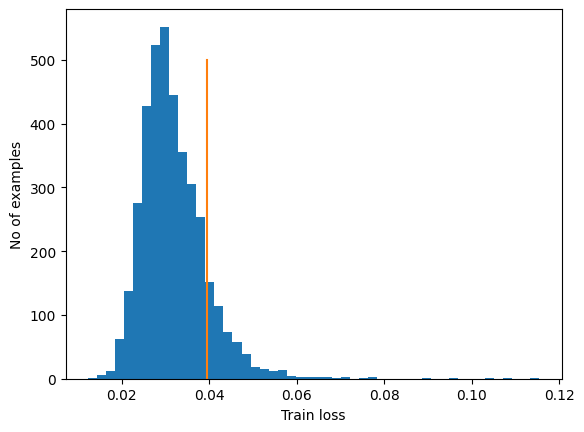

In [ ]:
plt.hist(train_loss, bins = 50)
plt.plot(x, y)
plt.xlabel('Train loss')
plt.ylabel('No of examples')
plt.show()

So, we get the threshold value and the number of pneumonia images that we've lost meaning we've classified as normal

In [ ]:
nr_reconstructions = autoencoder.predict(X_nr_train)
nr_train_loss = tf.keras.losses.mae(nr_reconstructions, X_nr_train)
nr_train_loss = np.mean(nr_train_loss, axis=(1, 2))

42/42 [==============================] - 44s 1s/step


In [ ]:
y1 = np.linspace(0, 100)
x1 = [ad_threshold]*50

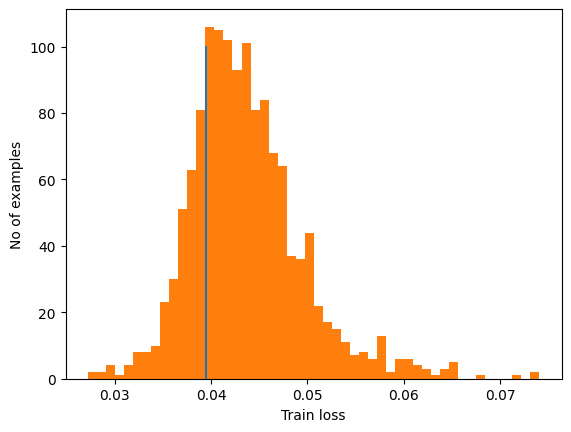

In [ ]:
plt.plot(x1, y1)
plt.hist(nr_train_loss, bins = 50)
plt.xlabel('Train loss')
plt.ylabel('No of examples')
plt.show()

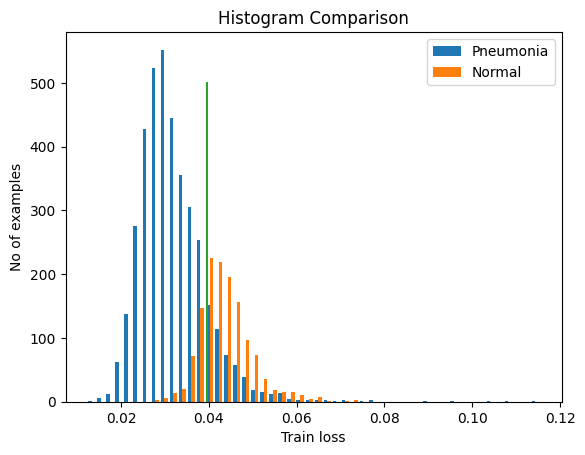

In [ ]:
plt.hist([train_loss, nr_train_loss], bins=50, label=['Pneumonia', 'Normal'])
plt.plot(x, y)
plt.xlabel('Train loss')
plt.ylabel('No of examples')
plt.title('Histogram Comparison')
plt.legend()
plt.show()

Then, if the loss is less than the threshold, the image will be classified as pneumonia. Else, it will be classified as normal.

In [ ]:
def load_test_encoder_data(path):
    test_data = []
    X_test = []
    y_test = []
    categories = os.listdir(path)
    img_size = 160
    for category in categories:
        full_path = os.path.join(path,category)
        cat_index = categories.index(category)
        files = os.listdir(full_path)
        for image in tqdm(files):
            image_arr = cv2.imread(os.path.join(full_path,image),cv2.IMREAD_GRAYSCALE)
            resized_image_arr = cv2.resize(image_arr,(img_size,img_size))
            test_data.append([resized_image_arr,cat_index])
    random.shuffle(test_data)
    for x,y in test_data:
        X_test.append(x)
        y_test.append(y)
    test_mapping = {category:categories.index(category) for category in categories}
    X_test = np.array(X_test).reshape(-1,img_size,img_size,1)
    X_test = np.array(X_test)/255.0
    return X_test, y_test

In [ ]:
X_ftest, y_ftest = load_test_encoder_data('/content/chest_xray/test')
X_ftrain, y_ftrain = load_test_encoder_data('/content/chest_xray/train')

100%|██████████| 3875/3875 [00:24<00:00, 157.25it/s]


Accuracy of the prediction

In [ ]:
def predict(model, data, threshold):
  reconstructions = model.predict(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  loss = np.mean(loss, axis = (1,2))
  return tf.math.less(loss, threshold)

In [ ]:
def stats(predictions, labels):
  print(accuracy_score(labels, predictions))

In [ ]:
preds = predict(autoencoder, X_ftrain, ad_threshold)
stats(preds, y_ftrain)

163/163 [==============================] - 156s 959ms/step
0.7668711656441718


In [ ]:
test_pn_reconstructions = autoencoder.predict(X_pn_test)
test_loss = tf.keras.losses.mae(test_pn_reconstructions, X_pn_test)
test_loss = np.mean(test_loss, axis=(1, 2))

13/13 [==============================] - 16s 1s/step


In [ ]:
test_nr_reconstructions = autoencoder.predict(X_nr_test)
nr_test_loss = tf.keras.losses.mae(test_nr_reconstructions, X_nr_test)
nr_test_loss = np.mean(nr_test_loss, axis=(1, 2))

8/8 [==============================] - 8s 1s/step


In [ ]:
y2 = np.linspace(0, 50)
x2 = [ad_threshold]*50

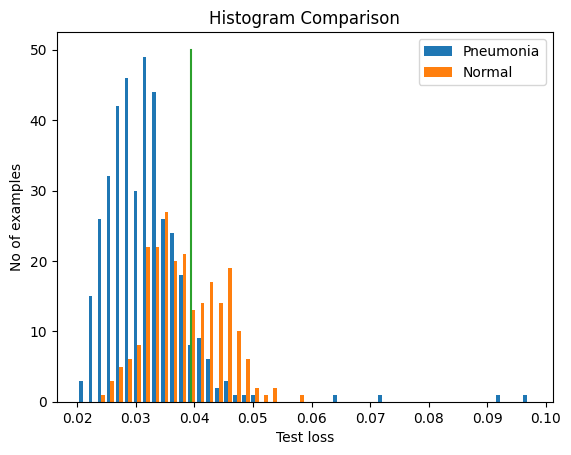

In [ ]:
plt.hist([test_loss, nr_test_loss], bins=50, label=['Pneumonia', 'Normal'])
plt.plot(x2, y2)
plt.xlabel('Test loss')
plt.ylabel('No of examples')
plt.title('Histogram Comparison')
plt.legend()
plt.show()

In [ ]:
preds = predict(autoencoder, X_ftest, ad_threshold)
stats(preds, y_ftest)

20/20 [==============================] - 18s 876ms/step
0.6490384615384616


Testing

In [ ]:
image_path = '/content/chest_xray/val/NORMAL/NORMAL2-IM-1437-0001.jpeg'
img_size = 160
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
image = cv2.resize(image, (img_size,img_size))
image_arr = np.array(image).reshape(1, img_size,img_size,1)
image_arr = np.array(image_arr)/255.0

In [ ]:
print(image_arr.shape)

(1, 160, 160, 1)


1/1 [==============================] - 0s 27ms/step
[0.0225654]


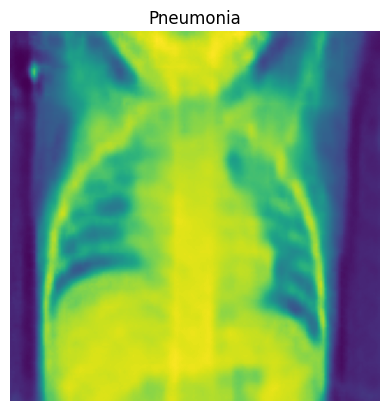

In [ ]:
img_reconstruction = autoencoder.predict(image_arr)
loss = tf.keras.losses.mae(img_reconstruction, image_arr)
loss = np.mean(loss, axis = (1,2))
print(loss)
if loss <0.033:
  label = 'Pneumonia'
else:
  label = 'Normal'
plt.Figure(figsize = (16, 8))
plt.subplot(1,2,1)
plt.imshow(img_reconstruction.reshape(img_size, img_size, 1))
plt.title(label)
plt.subplot(1,2,2)
plt.imshow(image_arr.reshape(img_size, img_size, 1))
plt.title(label)
plt.axis('off')
plt.show()